In [4]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import pandas as pd
import utility
import meshing
import networkx as nx
import function_normals
from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from numpy.polynomial import polynomial as poly

In [5]:
import importlib
importlib.reload(utility)

<module 'utility' from 'E:\\Data\\knorpel_v2\\utility.py'>

In [6]:
#sitk_image, np_image = utility.read_image('9144760_segm.mhd')
sitk_image, np_image = utility.read_image('C:/users/simon/downloads/mask.nii.gz')
femoral_cartilage = utility.build_3d_cartilage_array(np_image, 3)
tibial_cartilage = utility.build_3d_cartilage_array(np_image, 4)
femoral_vectors = [list(element) for element in femoral_cartilage]
tibial_vectors = [list(element) for element in tibial_cartilage]
cwbzl, cwbzr = utility.extract_central_weightbearing_zone(femoral_vectors, tibial_vectors)
lpdf, rpdf, adf = utility.extract_anterior_posterior_zones(femoral_vectors, cwbzl, cwbzr)
ladf, radf = utility.split_anterior_part(adf)

c:\programdata\anaconda3\envs\knorpel_v2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
c:\programdata\anaconda3\envs\knorpel_v2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


# Plots

## 2D plots

In [18]:
xs, layers = function_normals.build_cwbz_layers(cwbzl)
layer = layers[10]
x = np.array([x[0] for x in layer])
y = np.array([x[1] for x in layer])
z = poly.polyfit(x, y, 3)
der = poly.polyder(z)
fun = poly.polyval(x, z)
new_x = np.arange(min(x), max(x))
# normals = [poly.polyval(val, z) - (1 / poly.polyval(val, der)) * (new_x - val) for val in new_x]
normals = [(-1/poly.polyval(val, der)) * new_x + (poly.polyval(val, z) - (-1/poly.polyval(val, der)) * val) for val in new_x]

In [19]:
len(np.arange(min([x[0] for x in layer]), max([x[0] for x in layer])))

31

In [20]:
poly.polyval(50, der) * new_x + (poly.polyval(50, z) - poly.polyval(50, der) * 50)

array([251.97305595, 250.87940887, 249.78576179, 248.69211471,
       247.59846762, 246.50482054, 245.41117346, 244.31752638,
       243.2238793 , 242.13023222, 241.03658514, 239.94293806,
       238.84929098, 237.7556439 , 236.66199682, 235.56834974,
       234.47470266, 233.38105558, 232.2874085 , 231.19376142,
       230.10011434, 229.00646726, 227.91282018, 226.8191731 ,
       225.72552602, 224.63187894, 223.53823186, 222.44458478,
       221.3509377 , 220.25729062, 219.16364354])

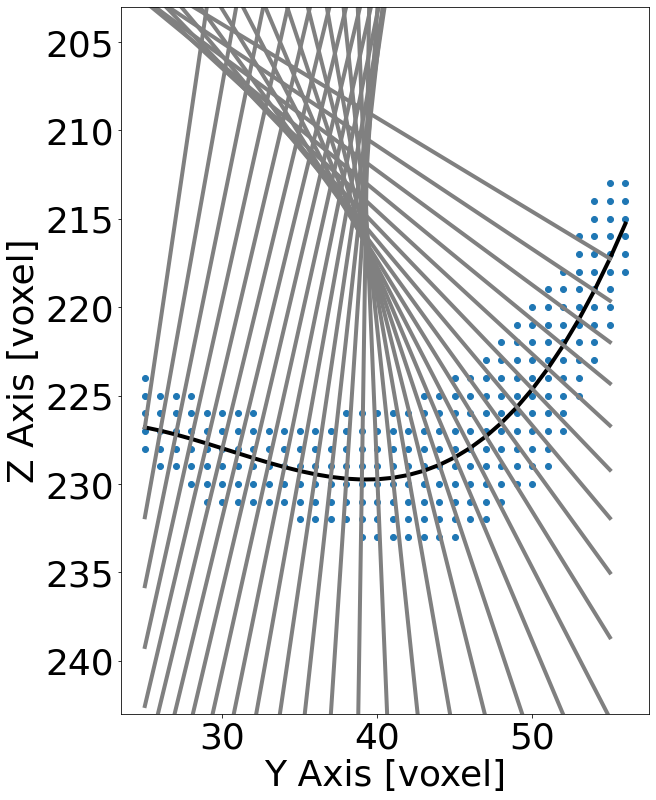

In [21]:
plt.rcParams.update({'font.size': 36, 'figure.autolayout': True})

fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(x=x, y=y)
ax.plot(x, fun, c='black', linewidth=4)
for normal in normals:
    ax.plot(new_x, normal, c='grey', linewidth=4)

ax.set_xlabel('Y Axis [voxel]')
ax.set_ylabel('Z Axis [voxel]')
plt.ylim(min(y) - 10, max(y) + 10)

ax.invert_yaxis()
fig.savefig('plots/cFN.png', facecolor='white')
#plt.show()

In [22]:
df = pd.DataFrame(layer, columns=['x', 'y'])
upper_points = df.groupby(by='x').max().reset_index()
lower_points = df.groupby(by='x').min().reset_index()
upper_fit = poly.polyfit(upper_points['x'], upper_points['y'], 3)
lower_fit = poly.polyfit(lower_points['x'], lower_points['y'], 3)
upper_fun = poly.polyval(x, upper_fit)
lower_fun = poly.polyval(x, lower_fit)
der = poly.polyder(lower_fit)
new_x = lower_points['x'].to_numpy()
normals = [poly.polyval(val, lower_fit) - (1 / poly.polyval(val, der)) * (new_x - val) for val in new_x]

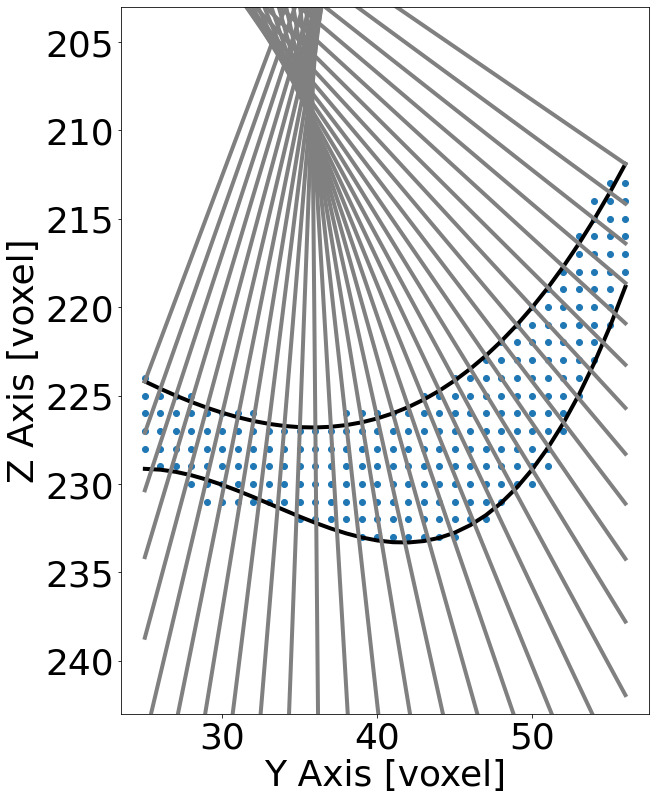

In [23]:
fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(x=x, y=y)

ax.plot(x, upper_fun, c='black', linewidth=4)
ax.plot(x, lower_fun, c='black', linewidth=4)
for normal in normals:
    ax.plot(new_x, normal, c='grey', linewidth=4)

plt.ylim(min(y) - 10, max(y) + 10)
ax.set_xlabel('Y Axis [voxel]')
ax.set_ylabel('Z Axis [voxel]')
ax.invert_yaxis()

fig.savefig(f'plots/sFN.png', facecolor='white')
#plt.show()

## Tibial subregions

In [7]:
df = pd.DataFrame(data=tibial_cartilage, columns=['x', 'y', 'z'])
max_z = df.groupby(['x', 'y']).max()

tmp1 = [np.array(item) for item in max_z.index]
tmp2 = [item for item in max_z.to_numpy()]
max_z = np.column_stack((tmp1, tmp2))

dd = defaultdict(list)
left_tibial_regions, right_tibial_regions, split_vector = utility.tibial_landmarks(max_z)
for v in max_z:
    vector = np.array(v)
    label = utility.classify_tibial_point(vector[:2], left_tibial_regions, right_tibial_regions, split_vector)
    dd[label].append(vector)

c:\programdata\anaconda3\envs\knorpel_v2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
c:\programdata\anaconda3\envs\knorpel_v2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


In [8]:
#pv.global_theme.font.size = 96
#pv.global_theme.font.label_size = 500 
p = pv.Plotter(window_size=[2560, 1440])
#p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(dd['iMT']), color='blue', point_size=20)
p.add_mesh(pv.PolyData(dd['aMT']), color='#03b3ff', point_size=15)
p.add_mesh(pv.PolyData(dd['eMT']), color='#0bff03', point_size=15)
p.add_mesh(pv.PolyData(dd['pMT']), color='yellow', point_size=15)
p.add_mesh(pv.PolyData(dd['cMT']), color='red', point_size=15)
p.add_mesh(pv.PolyData(dd['iLT']), color='blue', point_size=15)
p.add_mesh(pv.PolyData(dd['aLT']), color='#03b3ff', point_size=15)
p.add_mesh(pv.PolyData(dd['eLT']), color='#0bff03', point_size=15)
p.add_mesh(pv.PolyData(dd['pLT']), color='yellow', point_size=15)
p.add_mesh(pv.PolyData(dd['cLT']), color='red', point_size=15)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=48, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

p.show()
#p.screenshot('paper/figures/tibial_subregions.png')

ViewInteractiveWidget(height=1440, layout=Layout(height='auto', width='100%'), width=2560)

## Femoral subregions

In [9]:
lower_mesh_left, upper_mesh_left = utility.build_femoral_meshes(cwbzl)
lower_mesh_right, upper_mesh_right = utility.build_femoral_meshes(cwbzr)

left_landmarks = utility.femoral_landmarks(upper_mesh_left.points)
right_landmarks = utility.femoral_landmarks(upper_mesh_right.points)

dd = defaultdict(list)
for v in upper_mesh_left.points:
    vector = np.array(v)
    label = utility.classify_femoral_point(v[:2], left_landmarks, True)
    dd[label].append(vector)
    
for v in upper_mesh_right.points:
    vector = np.array(v)
    label = utility.classify_femoral_point(v[:2], right_landmarks, False)
    dd[label].append(vector)

In [10]:
#p = pv.Plotter(off_screen=True, window_size=[2560, 1440])
p = pv.Plotter()
#p.add_mesh(pv.PolyData(femoral_vectors), color='grey')
p.add_mesh(pv.PolyData(ladf.to_numpy()), color='#03b3ff', point_size=10)
p.add_mesh(pv.PolyData(radf.to_numpy()), color='#03b3ff', point_size=10)
p.add_mesh(pv.PolyData(cwbzl.to_numpy()), color='grey', point_size=10)
p.add_mesh(pv.PolyData(cwbzr.to_numpy()), color='grey', point_size=10)
p.add_mesh(pv.PolyData([[x[2], x[1], x[0]] for x in lpdf.to_numpy()]), color='yellow', point_size=10)
p.add_mesh(pv.PolyData([[x[2], x[1], x[0]] for x in rpdf.to_numpy()]), color='yellow', point_size=10)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=48, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

p.show()
#p.screenshot('paper/figures/femoral_subregions.png')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [11]:
p = pv.Plotter(window_size=[2560, 1440])
#p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(dd['ecMF']), color='0bff03', point_size=15)
p.add_mesh(pv.PolyData(dd['ccMF']), color='red', point_size=15)
p.add_mesh(pv.PolyData(dd['icMF']), color='blue', point_size=15)
p.add_mesh(pv.PolyData(dd['ecLF']), color='0bff03', point_size=15)
p.add_mesh(pv.PolyData(dd['ccLF']), color='red', point_size=15)
p.add_mesh(pv.PolyData(dd['icLF']), color='blue', point_size=15)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 315
p.camera.elevation = 180
p.enable_eye_dome_lighting()

p.show()
#p.screenshot('paper/figures/cwbz_subregions.png')

ViewInteractiveWidget(height=1440, layout=Layout(height='auto', width='100%'), width=2560)

## Tibial meshes

In [30]:
df = pd.DataFrame(data=tibial_cartilage, columns=['x', 'y', 'z'])
max_z = df.groupby(['x', 'y']).max()

tmp1 = [np.array(item) for item in max_z.index]
tmp2 = [item for item in max_z.to_numpy()]
max_z = np.column_stack((tmp1, tmp2))

left_tibial_landmarks, right_tibial_landmarks, split_vector = utility.tibial_landmarks(max_z)
left_plate, right_plate = utility.split_into_plates(tibial_vectors, split_vector)

lower_mesh_left, upper_mesh_left = utility.build_tibial_meshes(left_plate)
lower_mesh_right, upper_mesh_right = utility.build_tibial_meshes(right_plate)

In [58]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(lower_mesh_left, color='green')
p.add_mesh(upper_mesh_left, color='red')
p.add_mesh(lower_mesh_right, color='green')
p.add_mesh(upper_mesh_right, color='red')

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/tibial_meshes.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Femoral meshes

In [59]:
lower_mesh_left, upper_mesh_left = utility.build_femoral_meshes(cwbzl)
lower_mesh_right, upper_mesh_right = utility.build_femoral_meshes(cwbzr)
lp_lower_mesh, lp_upper_mesh = utility.build_tibial_meshes(lpdf.to_numpy())  # left (lateral) posterior region
rp_lower_mesh, rp_upper_mesh = utility.build_tibial_meshes(rpdf.to_numpy())  # right (medial) posterior region
la_lower_mesh, la_upper_mesh = utility.build_tibial_meshes(ladf.to_numpy())  # anterior region
ra_lower_mesh, ra_upper_mesh = utility.build_tibial_meshes(radf.to_numpy())

In [60]:
lp_lower_mesh.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in lp_lower_mesh.points])
lp_upper_mesh.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in lp_upper_mesh.points])
rp_lower_mesh.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in rp_lower_mesh.points])
rp_upper_mesh.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in rp_upper_mesh.points])

In [61]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])


p.add_mesh(lower_mesh_left, color='green')
p.add_mesh(upper_mesh_left, color='red')
p.add_mesh(lower_mesh_right, color='green')
p.add_mesh(upper_mesh_right, color='red')

p.add_mesh(lp_lower_mesh, color='green')
p.add_mesh(lp_upper_mesh, color='red')
p.add_mesh(rp_lower_mesh, color='green')
p.add_mesh(rp_upper_mesh, color='red')

p.add_mesh(la_lower_mesh, color='green')
p.add_mesh(la_upper_mesh, color='red')
p.add_mesh(ra_lower_mesh, color='green')
p.add_mesh(ra_upper_mesh, color='red')

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/femoral_meshes.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Sphere placement

In [13]:
"""center_lp = np.array([lpdf.x.min() + (lpdf.x.max() - lpdf.x.min()) / 2,
                          lpdf.y.min() + (lpdf.y.max() - lpdf.y.min()) / 2,
                          lpdf.z.min() + (lpdf.z.max() - lpdf.z.min()) / 2])"""
center_lp = np.array([lpdf.z.min() + (lpdf.z.max() - lpdf.z.min()) / 2,
                          lpdf.y.min() + (lpdf.y.max() - lpdf.y.min()) / 2,
                          lpdf.x.min() + (lpdf.x.max() - lpdf.x.min()) / 2])
sphere_lp = pv.Sphere(center=center_lp, radius=5, theta_resolution=10, phi_resolution=10)
sphere_lp.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107906f40)
  N Cells:	160
  N Points:	82
  X Bounds:	2.571e+02, 2.669e+02
  Y Bounds:	3.232e+01, 4.168e+01
  Z Bounds:	1.620e+02, 1.720e+02
  N Arrays:	1

In [14]:
#sphere_lp.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in sphere_lp.points])

In [15]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(sphere_lp)
p.add_arrows(sphere_lp.points, sphere_lp['Normals'], 10, show_scalar_bar=False, color='grey')
p.add_mesh(pv.PolyData([[x[2], x[1], x[0]] for x in lpdf.to_numpy()]), color='lightblue', point_size=10)
#p.add_mesh(pv.PolyData(lpdf.to_numpy()), color='green')


p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
#p.screenshot('paper/figures/sphere_placement_plf.png')
p.screenshot('paper/figures/sphere_rays.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [16]:
"""center_lp = np.array([lpdf.x.min() + (lpdf.x.max() - lpdf.x.min()) / 2,
                          lpdf.y.min() + (lpdf.y.max() - lpdf.y.min()) / 2,
                          lpdf.z.min() + (lpdf.z.max() - lpdf.z.min()) / 2])"""
center_lp = np.array([lpdf.z.min() + (lpdf.z.max() - lpdf.z.min()) / 2,
                          lpdf.y.min() + (lpdf.y.max() - lpdf.y.min()) / 2,
                          lpdf.x.min() + (lpdf.x.max() - lpdf.x.min()) / 2])
sphere_lp = pv.Sphere(center=center_lp, radius=5, theta_resolution=60, phi_resolution=60)
sphere_lp.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107999dc0)
  N Cells:	6960
  N Points:	3482
  X Bounds:	2.570e+02, 2.670e+02
  Y Bounds:	3.200e+01, 4.200e+01
  Z Bounds:	1.620e+02, 1.720e+02
  N Arrays:	1

In [17]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(sphere_lp)
p.add_mesh(pv.PolyData([[x[2], x[1], x[0]] for x in lpdf.to_numpy()]), color='lightblue', point_size=10)
#p.add_mesh(pv.PolyData(lpdf.to_numpy()), color='green')


p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_plf.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [18]:
center_rp = np.array([rpdf.x.min() + (rpdf.x.max() - rpdf.x.min()) / 2,
                          rpdf.y.min() + (rpdf.y.max() - rpdf.y.min()) / 2,
                          rpdf.z.min() + (rpdf.z.max() - rpdf.z.min()) / 2])
sphere_rp = pv.Sphere(center=center_rp, radius=5, theta_resolution=60, phi_resolution=60)
sphere_rp.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107c2a9a0)
  N Cells:	6960
  N Points:	3482
  X Bounds:	1.585e+02, 1.685e+02
  Y Bounds:	1.060e+02, 1.160e+02
  Z Bounds:	2.545e+02, 2.645e+02
  N Arrays:	1

In [19]:
sphere_rp.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in sphere_rp.points])

In [20]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData([[x[2], x[1], x[0]] for x in rpdf.to_numpy()]), color='lightblue', point_size=10)
p.add_mesh(sphere_rp)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_pmf.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [21]:
center_lc = np.array([cwbzl.x.min() + (cwbzl.x.max() - cwbzl.x.min()) / 2,
                            cwbzl.y.min() + (cwbzl.y.max() - cwbzl.y.min()) / 2,
                            cwbzl.z.min() - (cwbzl.z.max() - cwbzl.z.min()) / 4])
sphere_lc = pv.Sphere(center=center_lc, radius=5, theta_resolution=60, phi_resolution=60)
sphere_lc.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107bff880)
  N Cells:	6960
  N Points:	3482
  X Bounds:	2.135e+02, 2.235e+02
  Y Bounds:	3.650e+01, 4.650e+01
  Z Bounds:	2.025e+02, 2.125e+02
  N Arrays:	1

In [39]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(cwbzl.to_numpy()), color='lightblue', point_size=25)
p.add_mesh(sphere_lc)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 330
p.camera.elevation = 165
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_cwbzl.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [23]:
center_rc = np.array([cwbzr.x.min() + (cwbzr.x.max() - cwbzr.x.min()) / 2,
                             cwbzr.y.min() + (cwbzr.y.max() - cwbzr.y.min()) / 2,
                             cwbzr.z.min() - (cwbzr.z.max() - cwbzr.z.min()) / 4])
sphere_rc = pv.Sphere(center=center_rc, radius=5, theta_resolution=60, phi_resolution=60)
sphere_rc.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107c13580)
  N Cells:	6960
  N Points:	3482
  X Bounds:	2.120e+02, 2.220e+02
  Y Bounds:	1.050e+02, 1.150e+02
  Z Bounds:	1.865e+02, 1.965e+02
  N Arrays:	1

In [42]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(cwbzr.to_numpy()), color='lightblue', point_size=20)
p.add_mesh(sphere_rc)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_cwbzr.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [25]:
center_la = np.array([ladf.x.min() + ((ladf.x.max() - ladf.x.min()) / 4) * 3,
                          ladf.y.min() + (ladf.y.max() - ladf.y.min()) / 2,
                          ladf.z.min() + (ladf.z.max() - ladf.z.min()) / 4])
sphere_la = pv.Sphere(center=center_la, radius=5, theta_resolution=60, phi_resolution=60)
sphere_la.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107bfe160)
  N Cells:	6960
  N Points:	3482
  X Bounds:	1.698e+02, 1.797e+02
  Y Bounds:	4.500e+01, 5.500e+01
  Z Bounds:	1.522e+02, 1.622e+02
  N Arrays:	1

In [26]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(ladf.to_numpy()), color='lightblue', point_size=10)
p.add_mesh(sphere_la)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_alf.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [27]:
center_ra = np.array([radf.x.min() + ((radf.x.max() - radf.x.min()) / 4) * 3,
                          radf.y.min() + (radf.y.max() - radf.y.min()) / 2,
                          radf.z.min() + (radf.z.max() - radf.z.min()) / 4])
sphere_ra = pv.Sphere(center=center_ra, radius=5, theta_resolution=60, phi_resolution=60)
sphere_ra.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x21107a41100)
  N Cells:	6960
  N Points:	3482
  X Bounds:	1.645e+02, 1.745e+02
  Y Bounds:	9.900e+01, 1.090e+02
  Z Bounds:	1.415e+02, 1.515e+02
  N Arrays:	1

In [28]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(radf.to_numpy()), color='lightblue', point_size=10)
p.add_mesh(sphere_ra)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_amf.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [31]:
ldf = pd.DataFrame(left_plate, columns=['x', 'y', 'z'])
center = np.array([ldf.x.min() + (ldf.x.max() - ldf.x.min()) / 2,
                       ldf.y.min() + (ldf.y.max() - ldf.y.min()) / 2,
                       ldf.z.max() * 1.25])
sphere = pv.Sphere(center=center, radius=5, theta_resolution=60, phi_resolution=60)
#sphere.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in sphere.points])

In [32]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(ldf.to_numpy()), color='lightblue', point_size=10)
p.add_mesh(sphere)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_lt.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [33]:
mdf = pd.DataFrame(right_plate, columns=['x', 'y', 'z'])
center = np.array([mdf.x.min() + (mdf.x.max() - mdf.x.min()) / 2,
                       mdf.y.min() + (mdf.y.max() - mdf.y.min()) / 2,
                       mdf.z.max() * 1.25])
sphere = pv.Sphere(center=center, radius=5, theta_resolution=60, phi_resolution=60)
#sphere.points = pv.pyvista_ndarray([[x[2], x[1], x[0]] for x in sphere.points])

In [34]:
#p = pv.Plotter()
p = pv.Plotter(off_screen=True, window_size=[2560, 1440])

p.add_mesh(pv.PolyData(mdf.to_numpy()), color='lightblue', point_size=10)
p.add_mesh(sphere)

p.set_background('w')
p.show_grid(color='black', use_2d=True, font_size=36, xlabel=' ', ylabel=' ', zlabel=' ', font_family='courier')
p.camera.azimuth = 270
p.camera.elevation = 180
p.enable_eye_dome_lighting()

#p.show()
p.screenshot('paper/figures/sphere_placement_mt.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [51]:
p = pv.Plotter()
#p.set_background('black')
p.add_mesh(pv.PolyData(ladf.to_numpy()), color='red')
p.add_mesh(pv.PolyData(radf.to_numpy()), color='green')
p.enable_eye_dome_lighting()
p.camera_position = 'yz'
p.camera.azimuth = 180
p.camera.elevation =  90
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [52]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(cwbzl.to_numpy()), color='red')
p.add_mesh(pv.PolyData(cwbzr.to_numpy()), color='green')
p.add_mesh(pv.PolyData(lpdf.to_numpy()), color='yellow')
p.add_mesh(pv.PolyData(rpdf.to_numpy()), color='orange')
p.add_mesh(pv.PolyData(adf.to_numpy()), color='cyan')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [4]:
a_lower_mesh, a_upper_mesh = utility.build_tibial_meshes(adf.to_numpy())

In [5]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(a_upper_mesh.points))
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [6]:
df = pd.DataFrame(a_upper_mesh.points, columns=['x', 'y', 'z'])
df

,x,y,z
0,75,109,142
1,76,107,145
2,76,108,145
3,76,109,144
4,76,110,144
...,...,...,...
9381,202,54,226
9382,202,55,225
9383,202,56,223
9384,202,57,221


In [7]:
graph = nx.Graph()

for index, row in tqdm(df.iterrows()):
    x = row['x']
    y = row['y']
    z = row['z']
    edges = list()
    
    if (tmp := df.loc[df['x'] == x - 1].loc[df['y'] == y]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x - 1].loc[df['y'] == y - 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x - 1].loc[df['y'] == y + 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x + 1].loc[df['y'] == y]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x + 1].loc[df['y'] == y - 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x + 1].loc[df['y'] == y + 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
        
    if (tmp := df.loc[df['x'] == x].loc[df['y'] == y - 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    if (tmp := df.loc[df['x'] == x].loc[df['y'] == y + 1]).shape[0] > 0:
        w = -(z - int(tmp['z']))
        if w < 0:
            w = 1
        elif w == 0:
            w = 2
        elif w > 0:
            w = 3
        
        edges.append((index, tmp.index[0], w))
    
    graph.add_weighted_edges_from(edges)

9386it [00:39, 234.77it/s]


In [8]:
start = df.loc[df['y'] == df['y'].median()].sort_values(by='x', ascending=True)
start = start.iloc[int(start.shape[0] / 2)].name
end = df.loc[df['y'] == df['y'].median()].sort_values(by='x', ascending=False).iloc[0].name

path = nx.dijkstra_path(graph, start, end, weight='weight')

In [9]:
tmp = df.groupby(by='x').min().reset_index()[['x', 'z']]
indices = []
for index, row in tmp.iterrows():
    if (a := df.loc[df['x'] == row['x']].loc[df['z'] == row['z']]).shape[0] > 0:
        indices.append(list(a.index))

indices = np.hstack((indices))

In [10]:
indices

array([   0,    3,    4,    5,   11,   20,   31,   45,   60,   77,   95,
        115,  136,  158,  182,  207,  233,  260,  289,  321,  359,  400,
        445,  493,  544,  599,  660,  724,  795,  796,  797,  798,  868,
        941, 1013, 1014, 1086, 1087, 1159, 1230, 1231, 1232, 1302, 1303,
       1304, 1305, 1306, 1378, 1379, 1380, 1381, 1454, 1455, 1528, 1529,
       1530, 1531, 1603, 1604, 1605, 1606, 1679, 1680, 1681, 1756, 1757,
       1832, 1906, 1907, 1908, 1909, 1910, 1985, 2059, 2060, 2061, 2136,
       2212, 2213, 2214, 2290, 2291, 2368, 2369, 2447, 2448, 2525, 2526,
       2527, 2528, 2605, 2606, 2607, 2608, 2685, 2686, 2687, 2688, 2689,
       2766, 2767, 2768, 2769, 2770, 2850, 2931, 2932, 3013, 3014, 3015,
       3095, 3096, 3097, 3098, 3099, 3100, 3101, 3177, 3178, 3179, 3180,
       3181, 3182, 3183, 3184, 3262, 3263, 3264, 3265, 3267, 3345, 3346,
       3347, 3348, 3349, 3351, 3352, 3432, 3516, 3517, 3601, 3602, 3605,
       3606, 3686, 3687, 3688, 3689, 3690, 3691, 36

In [11]:
valley = df.iloc[indices]
valley = valley[np.abs(stats.zscore(valley['y'])) < 1]

In [12]:
left_part = df.loc[df['y'] < valley['y'].median()]
right_part = df.loc[df['y'] > valley['y'].median()]

In [13]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(a_upper_mesh.points))
p.add_mesh(pv.PolyData(left_part.to_numpy()), color='yellow')
p.add_mesh(pv.PolyData(right_part.to_numpy()), color='orange')
p.add_mesh(pv.PolyData(valley.to_numpy()), color='cyan')
p.add_mesh(pv.PolyData(df.iloc[path].to_numpy()), color='red')
p.add_mesh(pv.PolyData(df.iloc[start].to_numpy()), color='green')
p.add_mesh(pv.PolyData(df.iloc[end].to_numpy()), color='blue')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)